<a href="https://colab.research.google.com/github/Akshay-Kumar-Arya/Identify_the_sentiments/blob/master/models/ULMFit_in_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import spacy
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_colwidth', 500)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Data path
training_data_path = "/content/gdrive/My Drive/Identify_the_sentiments/train.csv"
test_data_path =  "/content/gdrive/My Drive/Identify_the_sentiments/test.csv"

save_path = "/content/gdrive/My Drive/Identify_the_sentiments/"

In [6]:
# reading data from csv
train_data = pd.read_csv(training_data_path)
test_data = pd.read_csv(test_data_path)

print (train_data.shape, test_data.shape)

(7920, 3) (1953, 2)


In [7]:
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


## Text Preprocessing and visualization

In [8]:
# removing URLs from data 
# we can also use "https[\S]*" pattern
train_data['clean_tweet'] = train_data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
test_data['clean_tweet'] = test_data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))

In [9]:
# remove twitter handles
train_data['clean_tweet'] = train_data['clean_tweet'].apply(lambda x: re.sub("@[\w]*", '', x))
test_data['clean_tweet'] = test_data['clean_tweet'].apply(lambda x: re.sub("@[\w]*", '', x))

In [10]:
# convert to lower case

train_data['clean_tweet'] = train_data['clean_tweet'].str.lower()
test_data['clean_tweet'] = test_data['clean_tweet'].str.lower()

**Are hashtags are useful words? Let's see**

In [ ]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


In [189]:
# function to print barplot for hashtag words against their frequency.

def print_hashtags():
  # extracting hashtags from positive tweets
  HT_regular = hashtag_extract(train_data['clean_tweet'][train_data['label'] == 0])

  # extracting hashtags from Negative tweets
  HT_negative = hashtag_extract(train_data['clean_tweet'][train_data['label'] == 1])

  # unnesting list
  HT_regular = sum(HT_regular,[])
  HT_negative = sum(HT_negative,[])

  # Print top 10 #tags in positive tweets
  a = nltk.FreqDist(HT_regular)
  d = pd.DataFrame({'Hashtag': list(a.keys()),
                    'Count': list(a.values())})
  # selecting top 10 most frequent hashtags     
  d = d.nlargest(columns="Count", n = 20)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
  ax.set_title('Positive tweets')
  plt.show()


  # Print top10 hashtags in negative tweets
  b = nltk.FreqDist(HT_negative)
  e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
  # selecting top 10 most frequent hashtags
  e = e.nlargest(columns="Count", n = 20)   
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
  ax.set_title('Negative tweets')
  plt.show()

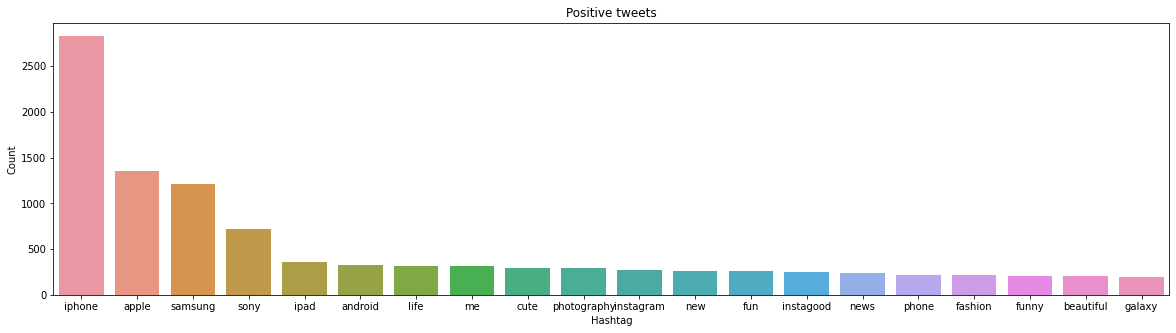

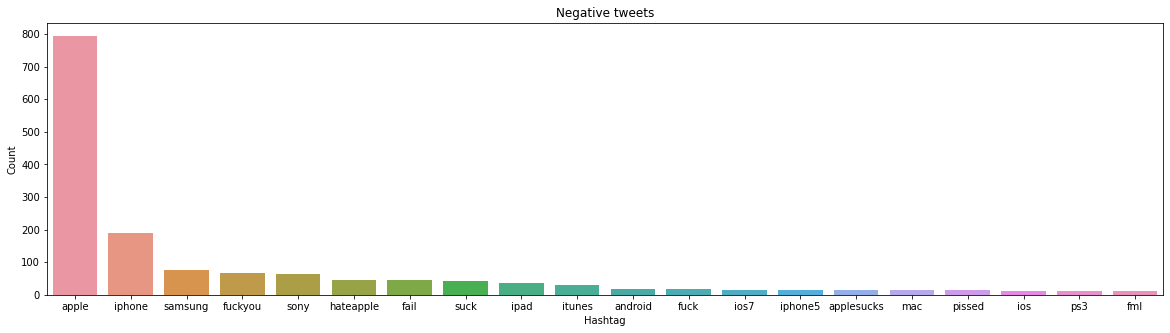

In [191]:
print_hashtags()

In [11]:
# remove 6 most frequent unrelatable word to positive or negative tweets
words = ["#apple", "#iphone", "#samsung", "#sony", "#ipad", "#android"]

for w in words:
  train_data['clean_tweet'] = train_data['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if not w in words]))
  test_data['clean_tweet'] = test_data['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if not w in words]))

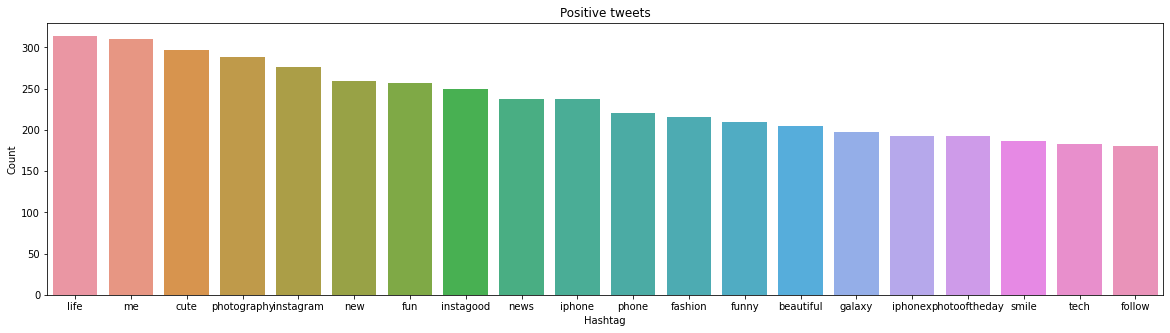

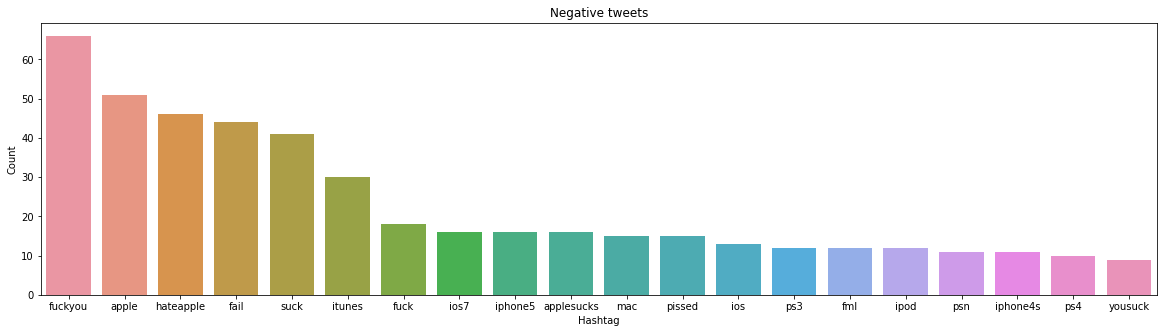

In [209]:
# After removing hashtags
print_hashtags()

In [12]:
# get rid of punctuations numbers and special characters in one call. Don't remove ' char
train_data['clean_tweet'] = train_data['clean_tweet'].str.replace("[^a-z']", " ")
test_data['clean_tweet'] = test_data['clean_tweet'].str.replace("[^a-z']", " ")

In [13]:
# remove white spaces

train_data['clean_tweet'] = train_data['clean_tweet'].apply(lambda x: ' '.join(x.split()))
test_data['clean_tweet'] = test_data['clean_tweet'].apply(lambda x: ' '.join(x.split()))

In [14]:
train_data.head()

,id,label,tweet,clean_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test apps beautiful cute health igers iphoneonly iphonesia
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thanks to my uncle yay xperia s sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,we love this would you go talk makememories unplug relax smartphone wifi connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,i'm wired i know i'm george i was made that way cute daventry home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple won't even talk to me about a question i have unless i pay them for their stupid support


In [15]:
# lammetizing the tweets
# converting them into their base form
nlp = spacy.load('en', disable=['parser', 'ner'])

# Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.
# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

train_data['clean_tweet'] = lemmatization(train_data['clean_tweet'])
test_data['clean_tweet'] = lemmatization(test_data['clean_tweet'])

In [131]:
train_data.head()

,id,label,tweet,clean_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,# fingerprint # pregnancy test # android # apps # beautiful # cute # health # iger # iphoneonly # iphonesia # iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thank to -PRON- uncle # yay # sony # xperia # s # sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,-PRON- love this would -PRON- go # talk # makememorie # unplug # relax # iphone # smartphone # wifi # connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,-PRON- be wire i know -PRON- be george i be make that way # iphone # cute # daventry # home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple will not even talk to -PRON- about a question i have unless i pay -PRON- for -PRON- stupid support


In [16]:
# remove the -PRON- character stands for pronoun(given by spacy lib)
train_data['clean_tweet'] = train_data['clean_tweet'].apply(lambda x: ' '.join(w for w in x.split() if w != "-PRON-"))
test_data['clean_tweet'] = test_data['clean_tweet'].apply(lambda x: ' '.join(w for w in x.split() if w != "-PRON-"))

In [111]:
train_data.head()

,id,label,tweet,clean_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health iger iphoneonly iphonesia iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thank to uncle yay sony xperia s sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,love this would go talk makememorie unplug relax iphone smartphone wifi connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,be wire i know be george i be make that way iphone cute daventry home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple will not even talk to about a question i have unless i pay for stupid support


In [ ]:
# import the stopwords from nltk
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(df):
  # tokenization 
  tokenized_doc = df['clean_tweet'].apply(lambda x: x.split())

  # remove stop-words 
  tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

  # de-tokenization 
  detokenized_doc = [] 
  for i in range(len(df)): 
      t = ' '.join(tokenized_doc[i]) 
      detokenized_doc.append(t) 

  df['clean_tweet'] = detokenized_doc
  return df

In [ ]:
train_data = remove_stopwords(train_data)
test_data = remove_stopwords(test_data)

In [ ]:
# function for making train and test data with only useful columns
def make_train_df(x):
  df = pd.DataFrame()
  df['label'] = x['label']
  df['text'] = x['clean_tweet']
  return df

def make_test_df(x):
  df = pd.DataFrame()
  df['id'] = x['id']
  df['text'] = x['clean_tweet']
  return df

In [ ]:
train = make_train_df(train_data)
test =  make_test_df(test_data)

In [ ]:
train.head(), test.head()

(   label                                                                            text
 0      0  fingerprint pregnancy test app beautiful cute health iger iphoneonly iphonesia
 1      0            finally transparant silicon case thank uncle yay xperia sonyexperias
 2      0             love would go talk makememorie unplug relax smartphone wifi connect
 3      0                                    wire know george make way cute daventry home
 4      1              amazing service apple even talk question unless pay stupid support,
      id                                                                         text
 0  7921                                   hate new upgrade let download app ugh suck
 1  7922              currently shit fucking pant imac cashmoney raddest swagswagswag
 2  7923                 would like put cd rom ipad possible ' yes would block screen
 3  7924  ipod officially dead lose picture video sos concert vet camp hatinglife sob
 4  7925                     

### Visulualizing the cleaned tweets

In [112]:
# Number of positive and negative fraction in training dataset
print(f"Number of training examples: {train_data.shape[0]}", '\n')
print(f"Number of test examples: {test_data.shape[0]}", '\n')

print(f"The fraction of positive and negative comments:")
print(train_data['label'].value_counts(normalize = True), '\n')

Number of training examples: 7920 

Number of test examples: 1953 

The fraction of positive and negative comments:
0    0.744192
1    0.255808
Name: label, dtype: float64 



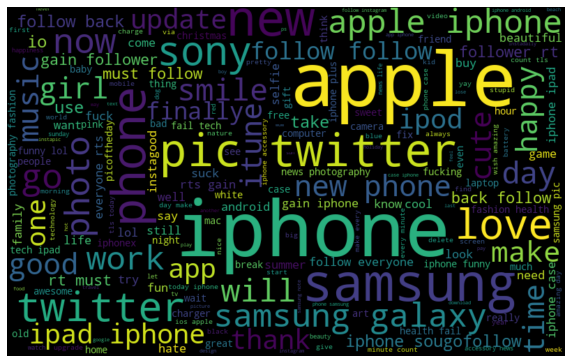

In [116]:
# Let’s visualize all the words our data using the wordcloud plot.
all_words = ' '.join([text for text in train_data['clean_tweet']])

from wordcloud import WordCloud
wc = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

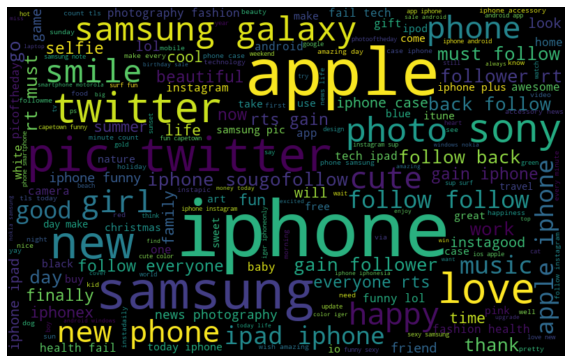

In [122]:
# words in positive tweets
all_words = ' '.join([text for text in train_data['clean_tweet'][train_data['label']==0]])

from wordcloud import WordCloud
wc = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

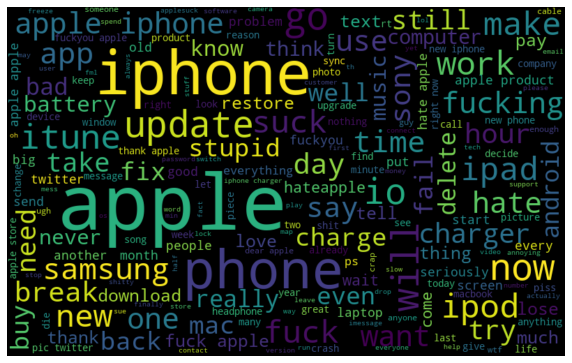

In [123]:
# words in negative tweets
all_words = ' '.join([text for text in train_data['clean_tweet'][train_data['label']==1]])

from wordcloud import WordCloud
wc = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Transfer learning using pytorch and fastai

In [1]:
!pip install -q torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install -q fastai

     |████████████████████████████████| 704.8MB 27kB/s 


In [2]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', 500)

In [38]:
# split data into training and validation set
df_train, df_val = train_test_split(train, stratify = train['label'], test_size = 0.2, random_state = 12)

In [39]:
df_train.shape, df_val.shape

((6336, 2), (1584, 2))

In [40]:
df_train.head()

,label,text
960,0,finally new phone galaxy muchneede excited thenextbigthing
1059,1,ios kill ripcameraroll ripiphoto nocameraroll noiphoto sad
7045,1,resend previous tweet ban product wife life
2417,1,longer update estimate time remain continue increase
5150,0,smoker model modelsearch modelstatus models model modellife instaspre integral gabbar smoker modelagency actor tbt gabbar


In [41]:
df_val.head()

,label,text
7742,1,hitler inform rant apple ipad ipadsuck
6583,0,jack inside tree uk general picture good god nice day family today rain
5196,1,think although itunes still bugger
3502,1,message top button officially break win
5917,0,beauty shopping aliusaexpress ios app new edition lenovo ideacentre high performance fl


In [43]:
# prepare our data for the language model and for the classification model separately.

# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_val, test_df=test, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_val, test_df=test, vocab=data_lm.train_ds.vocab, bs=32)

In [152]:
encoder = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True)

In [153]:
# train the learner object with learning rate = 1e-2
encoder.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.384287,7.510798,0.097723,00:06
1,8.024016,6.665705,0.110893,00:06
2,7.518416,5.967035,0.133259,00:06
3,7.032753,5.537431,0.192277,00:06
4,6.626044,5.316820,0.215937,00:06
5,6.284600,5.158597,0.227902,00:06
6,5.980848,5.017070,0.249375,00:06
7,5.712543,4.942505,0.257232,00:06
8,5.482203,4.895726,0.260491,00:06
9,5.272204,4.848146,0.273750,00:06


In [154]:
encoder.save_encoder('ft_enc')

In [155]:
learn = text_classifier_learner(data_clas, arch = AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6336 items)
x: TextList
xxbos finally new phone galaxy xxunk excited xxunk,xxbos ios kill xxunk xxunk xxunk xxunk sad,xxbos xxunk previous tweet ban product wife life,xxbos longer update estimate time xxunk continue increase,xxbos smoker model xxunk xxunk models model xxunk xxunk xxunk gabbar smoker xxunk actor tbt gabbar
y: CategoryList
0,1,1,1,0
Path: .;

Valid: LabelList (1584 items)
x: TextList
xxbos hitler xxunk rant apple ipad xxunk,xxbos jack inside tree uk general picture good god nice day family today rain,xxbos think xxunk itunes still bugger,xxbos message top button officially break win,xxbos beauty shopping aliusaexpress ios app new edition lenovo ideacentre high performance fl
y: CategoryList
1,0,1,1,0
Path: .;

Test: LabelList (1953 items)
x: TextList
xxbos hate new upgrade let download app ugh suck,xxbos currently shit fucking pant imac xxunk xxunk xxunk,xxbos would like put cd xxunk ipad possible ' yes would block sc

In [156]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.462061,0.388737,0.876263,00:07
1,0.366565,0.287722,0.868056,00:07
2,0.359002,0.272418,0.886995,00:06
3,0.367526,0.291586,0.885732,00:07
4,0.342853,0.269336,0.886995,00:06
5,0.324186,0.276747,0.872475,00:06
6,0.336103,0.268493,0.888889,00:06
7,0.327278,0.269694,0.890783,00:06
8,0.307694,0.268403,0.888889,00:06
9,0.313771,0.268813,0.885101,00:07


In [157]:
# get predictions
preds, labels = learn.get_preds(DatasetType.Test)

predictions = np.argmax(preds, axis = 1)
#pd.crosstab(predictions, targets)

In [158]:
# prepare submission dataframe
sub = pd.DataFrame({'id':test['id'], 'label':predictions.numpy()})

# write predictions to a CSV file
sub.to_csv(save_path + "sub_ULMFit.csv", index=False)
#Your score for this submission is : 0.8672838305718471.